## Model Training


### 1.1 Import Data and Required Packages

In [1]:
# Basic Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Modelling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/stud.csv')


In [3]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
X = df.drop(columns=['math_score'], axis=1)

In [5]:
correlation = X["reading_score"].corr(X["writing_score"])
print(f"Correlation between reading and writing score: {correlation:.2f}")


Correlation between reading and writing score: 0.95


In [6]:
X['reading_writing_avg'] = (X['reading_score'] + X['writing_score']) / 2
X.drop(['reading_score', 'writing_score'], axis=1, inplace=True)

In [7]:
y = df['math_score']


### Creating Column Transformer with 3 types of transformers

In [8]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(drop='first', sparse_output= False)

preprocessor = ColumnTransformer(
    [
        ("OnehotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)


### Separating Dataset into train and test data

In [9]:
from sklearn.model_selection import train_test_split

# Split the linear version
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

In [11]:
print(X_train.shape)
print(X_test.shape)


(800, 13)
(200, 13)


## Create an Evaluate Function to give all metrics after model Training

In [12]:
def evaluate_model(true,predicted):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae,rmse, r2_square

In [13]:
import pdb
import warnings
models = {
    
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=1.0, max_iter=10000),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
    
}
model_list = []
r2_list = []
warnings.simplefilter("error", RuntimeWarning)

for i in range(len(list(models))):
    model = list(models.values())[i]
    
    try:
        model.fit(X_train, y_train)
            
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)


        model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        print(list(models.keys())[i])
        model_list.append(list(models.keys())[i])

        print('Model performance for train data')
        print('- Root Mean Square Error is {:.4f}'.format(model_train_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
        print("- R2 Score: {:.4f}".format(model_train_r2))
        print('----------------------------------')
        
        print('Model performance for test data')
        print('- Root Mean Square Error is {:.4f}'.format(model_test_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
        print("- R2 Score: {:.4f}".format(model_test_r2))

        r2_list.append(model_test_r2)

        print('='*35)
        print('\n')
    except RuntimeWarning as e:
        print(f"RuntimeWarning caught: {e}")
        pdb.post_mortem()


Linear Regression
Model performance for train data
- Root Mean Square Error is 5.4080
- Mean Absolute Error: 4.3009
- R2 Score: 0.8703
----------------------------------
Model performance for test data
- Root Mean Square Error is 5.3997
- Mean Absolute Error: 4.2122
- R2 Score: 0.8802


Lasso
Model performance for train data
- Root Mean Square Error is 6.5923
- Mean Absolute Error: 5.2055
- R2 Score: 0.8072
----------------------------------
Model performance for test data
- Root Mean Square Error is 6.5139
- Mean Absolute Error: 5.1523
- R2 Score: 0.8256


Ridge
Model performance for train data
- Root Mean Square Error is 5.4082
- Mean Absolute Error: 4.3007
- R2 Score: 0.8703
----------------------------------
Model performance for test data
- Root Mean Square Error is 5.4045
- Mean Absolute Error: 4.2123
- R2 Score: 0.8800


K-Neighbors Regressor
Model performance for train data
- Root Mean Square Error is 6.0383
- Mean Absolute Error: 4.8235
- R2 Score: 0.8383
---------------------

In [14]:
print("Condition number of X_train:", np.linalg.cond(X_train))

Condition number of X_train: 7.748407409213891


## Results

In [15]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)


,Model Name,R2_Score
0,Linear Regression,0.880180
2,Ridge,0.879967
8,AdaBoost Regressor,0.851864
7,CatBoosting Regressor,0.841145
5,Random Forest Regressor,0.829338
1,Lasso,0.825632
6,XGBRegressor,0.802288
3,K-Neighbors Regressor,0.744542
4,Decision Tree,0.689768


## Linear Regression

In [16]:

lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.02


## Plotting y_pred and y_test

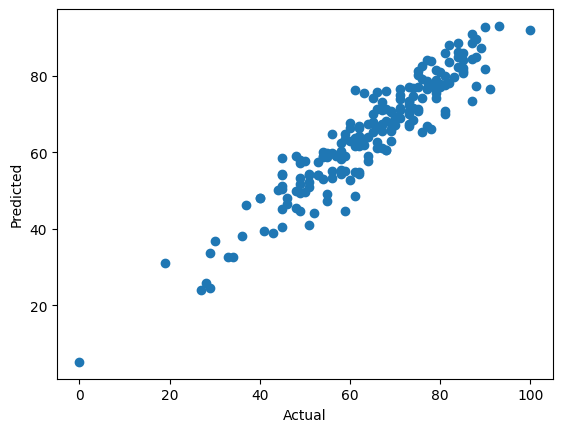

In [17]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

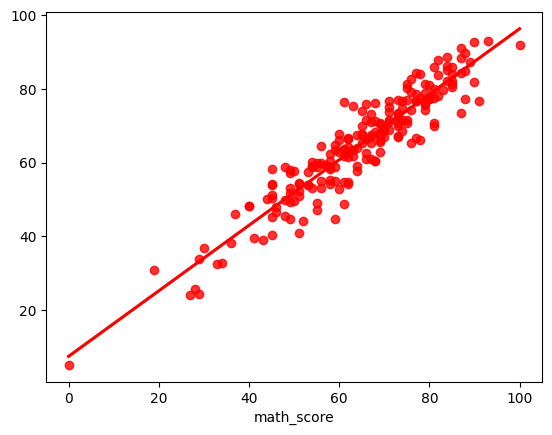

In [18]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');


### Difference between Actual and Predicted Values


In [19]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.656724,14.343276
737,53,57.362375,-4.362375
740,80,77.232963,2.767037
660,74,76.794050,-2.794050
411,84,88.627270,-4.627270
...,...,...,...
408,52,44.062446,7.937554
332,62,62.880864,-0.880864
208,74,68.501573,5.498427
613,65,67.616642,-2.616642
